Please fill out:

Student name: Fahima Hyder


Student pace:  part time


Scheduled project review date/time: April 5, 2019, 12 PM

Blog URL: https://fhyder.github.io/a_game_of_classification_models


Instructor name: Jeff Herman

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, f1_score
from sklearn import tree 

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


 <img src='robb.gif'>

## In the game of thrones you either win or you die...


Or.... you watch and enjoy a bowl of popcorn.

This notebook will attempt to build a model that will predict whether a character from HBO's Game of Thrones survives through the Winter. Using an extensive csv file that lists features of different characters in this fantasy world, I will use classifciation to make my predictions


In [2]:
#load the dataset
charac_pred = pd.read_csv('character-predictions.csv')

In [3]:
charac_pred.head()


S.No  actual  pred  alive   plod                  name  \
0     1       0     0  0.054  0.946  Viserys II Targaryen   
1     2       1     0  0.387  0.613           Walder Frey   
2     3       1     0  0.493  0.507          Addison Hill   
3     4       0     0  0.076  0.924           Aemma Arryn   
4     5       1     1  0.617  0.383        Sylva Santagar   

                  title  male   culture  dateOfBirth  ...  isAliveHeir  \
0                   NaN     1       NaN          NaN  ...          0.0   
1  Lord of the Crossing     1  Rivermen        208.0  ...          NaN   
2                   Ser     1       NaN          NaN  ...          NaN   
3                 Queen     0       NaN         82.0  ...          NaN   
4            Greenstone     0   Dornish        276.0  ...          NaN   

  isAliveSpouse isMarried isNoble   age numDeadRelations  boolDeadRelations  \
0           NaN         0       0   NaN               11                  1   
1           1.0         1       1  97.0                1                  1   
2           NaN         0       1   NaN                0                  0   
3           0.0         1       1  23.0                0                  0   
4           1.0         1       1  29.0                0                  0   

   isPopular  popularity  isAlive  
0          1    0.605351        0  
1          1    0.896321        1  
2          0    0.267559        1  
3          0    0.183946        0  
4          0    0.043478        1  

[5 rows x 33 columns]

Check the dataset info for data types and null values

In [4]:
charac_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
S.No                 1946 non-null int64
actual               1946 non-null int64
pred                 1946 non-null int64
alive                1946 non-null float64
plod                 1946 non-null float64
name                 1946 non-null object
title                938 non-null object
male                 1946 non-null int64
culture              677 non-null object
dateOfBirth          433 non-null float64
DateoFdeath          444 non-null float64
mother               21 non-null object
father               26 non-null object
heir                 23 non-null object
house                1519 non-null object
spouse               276 non-null object
book1                1946 non-null int64
book2                1946 non-null int64
book3                1946 non-null int64
book4                1946 non-null int64
book5                1946 non-null int64
isAliveMother        21 non

Several of the features are missing data and will be removed. Otherwise it seems that the only feature that needs to be made into dummies is 'house', let's work on that

In [5]:
charac_pred.house.unique() #first to see all the different houses represented here

array([nan, 'House Frey', 'House Swyft', 'House Arryn', 'House Santagar',
       'House Targaryen', 'House Osgrey', "Night's Watch", 'House Humble',
       'House Wylde', 'House Wode', 'House Fell',
       'Brotherhood Without Banners', 'House Webber', 'House Greyjoy',
       'House Stark', 'House Waynwood', 'House Dayne', 'House Manderly',
       'House Farwynd of the Lonely Light', 'Happy Port',
       'House of Loraq', 'Kingswood Brotherhood', 'House Botley',
       'Burned Men', 'House Velaryon', 'House Tallhart', 'House Tyrell',
       'House Blackwood', 'House Blackfyre', 'wildling',
       'Kingdom of the Three Daughters',
       'House Royce of the Gates of the Moon', 'House Nayland',
       "House Vance of Wayfarer's Rest", 'House Rowan', 'House Farrow',
       'House Lonmouth', 'House Reyne', 'House Ashford', 'House Brax',
       'House Paege', 'House Hollard', 'House Tarth', 'House Ryswell',
       'House Lannister', 'House Crakehall', 'House Darklyn',
       'House Westerli

WOW....that's a lot....exactly how much?

In [6]:
charac_pred.house.nunique()

347

Okay, so that's going to have to be broken into different categories but first lets clean up our dataset to reflect the features we want to work with


The following columns will be dropped because they are missing way too much data: isAliveMother, isAliveFather, isAliveHeir, isAliveSpouse, age

The following columns are being dropped because there's no real explanation on what they represent: S.no, pred, plod

Alive will be dropped because it is redundant with target isAlive

Popularity will be dropped because it is a score that is generated arbritrarily based on the opinion of the dataset's author. There's no clear rubric for this number and thereby it is arbritrary.


In [7]:
got = charac_pred.drop(['isAliveMother', 'isAliveFather','isAliveHeir', 'isAliveSpouse', 'age', 'S.No', 'actual', 'pred','plod' ,'title'  ], axis = 1)

In [8]:
got.drop(['mother', 'father', 'heir', 'spouse', 'culture', 'dateOfBirth', 'DateoFdeath', 'alive', 'boolDeadRelations', 'name', 'popularity'], axis = 1, inplace = True)

In [9]:
got.columns

Index(['male', 'house', 'book1', 'book2', 'book3', 'book4', 'book5',
       'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'isAlive'],
      dtype='object')

In [10]:
got.isna().sum()

male                  0
house               427
book1                 0
book2                 0
book3                 0
book4                 0
book5                 0
isMarried             0
isNoble               0
numDeadRelations      0
isPopular             0
isAlive               0
dtype: int64

Now I'll drop null values, there's less than half of the entire dataset

In [11]:
got.dropna(inplace = True)

In [12]:
len(got)

1519

Let's also drop characters that weren't present in any of the books

In [13]:
got = got[(got['book1'] == 1) | (got['book2'] == 1) | (got['book3'] == 1) | (got['book4'] == 1) | (got['book5'] == 1) ]


In [14]:
len(got)

1328

In [15]:
got.house.nunique()

327

Okay so that's 20 less houses. Great. Now let me really nerd out and categorize all of the houses by region.

# 3 Hours later ... 

In [16]:
riverlands = [ "House Bracken","House Whent","House Charlton","House Butterwell","House Smallwood","House Mallister","House Vance of Atranta","House Piper","House Strong","House Roote","House Lothston","House Pemford",
"House Haigh","House Wode","House Blackwood","House Vance of Wayfarer's Rest","House Nayland","House Paege","House Heddle", "House Ryger","House Baelish","House Hawick","House Cox","House Darry","House Grell","House Erenford","House Goodbrook","House Lychester","House Mooton","House Mudd","House Wayn","House Vypren","House Blanetree"]

reach = ["House Ambrose","House Bushy","House Beesbury","House Bulwer","House Caswell","House Conklyn","House Redwyne","House Risley","House Willum","House Uffering","House Norcross","House Fossoway of New Barrel", "House Serry","House Meadows",
"House Mullendore","House Florent","House Inchfield","House Cockshaw","House Graceford","House Osgrey","House Webber","House Rowan","House Ashford",
"House Leygood","House Fossoway of Cider Hall","House Varner","House Costayne","House Hightower","House Oakheart","House Hunt"
,"House Wythers","House Ball","House Cuy","House Merryweather","House Peake","House Rhysling","House Tarly","House Vyrwel","House Chester" , 
"House Grimm","House Hewett","House Norridge","House Blackbar","House Fossoway","House Crane","House Tyrell of Brightwater Keep"]
         
north = ["House Manderly","House Bolton of the Dreadfort","House Karstark","House Bolton","House Mormont","House Glover","House Hornwood","House Umber","House Woods","House Tallhart","House Ryswell","House Stout","House Harclay","House Norrey","House Cassel","House Cerwyn","House Condon","House Dustin","House Flint of Widow's Watch","House Flint","House Mollen","House Locke","House Poole","Thenn","House Woolfield","House Reed","House Liddle","House Wull"]


major = ["House Arryn","House Frey","House Greyjoy","House Frey of Riverrun","House Martell","House Lannister of Lannisport","House Tully","House Tyrell"] 
    
game_players = ["House Lannister of Casterly Rock" , "House Baratheon of Dragonstone","House Baratheon","House Baratheon of King's Landing","House Lannister","House Stark","House Targaryen" ]         



westerlands = ["House Swyft", "House Payne","House Plumm","House Clifton","House Lorch","House Lefford","House Yew","House Stackspear" ,"House Jast","House Reyne","House Brax","House Crakehall","House Westerling","House Spicer","House Clegane","House Broom","House Banefort","House Kenning of Kayce","House Marbrand" , "House Prester" , "House Greenfield" , "House Lydden","House Bettley" , "House Turnberry","House Vikary","House Sarsfield","House Yarwyck" ,"House Peckledon","House Hetherspoon","House Moreland" ,"House Farman"]                

dorne = ["House Santagar", "House Dalt" , "House Qorgyle", "House Manwoody","House Blackmont","House Ruttiger" , "House Estren","House Allyrion","House Dayne of High Hermitage","House Fowler","House Gargalen" , "House Jordayne" , "House Toland","House Uller","House Vaith","House Wells","House Yronwood","House Nymeros Martell","House Drinkwater" ]

defenders = ["Night's Watch","Second Sons","Brotherhood Without Banners","Stormcrows","Faceless Men","Sea watch","Queensguard","Brotherhood without banners","Kingsguard", "City Watch of King's Landing","Stone Crows","Brave Companions","Alchemists' Guild","Antler Men","Moon Brothers","wildling","Burned Men" , "Drowned men","R'hllor","Iron Bank of Braavos","brotherhood without banners","Three-eyed crow","Mance Rayder","Khal","Thirteen","Maesters","Citadel","Wise Masters","The Citadel","Good Masters" , "Undying Ones","Unsullied","Golden Company", "Faith of the Seven","Chataya's brothel","Kingswood Brotherhood","Kingdom of the Three Daughters","Band of Nine","Brotherhood without Banners","Company of the Cat","Summer Islands"]

crownlands = ["House Blackfyre","House Blount","House Byrch","House Bywater","House Chelsted" , "House Chyttering" , "House Darklyn" , "House Farring","House Gaunt","House Hayford","House Hogg","House Hollard","House Kettleblack","House Longwaters","House Mallery","House Massey","House Rosby","House Rykker","House Staunton","House Stokeworth","House Hardy","House Boggs","House Celtigar","House Velaryon","House Crabb","House Thorne","House Bar Emmon","House Brune of Brownhollow","House Brune of the Dyre Den" ,"House Sunglass","House Rambton", "House Slynt"]
 

ironislands = ["House Blacktyde","House Harlaw","House Codd" , "House Goodbrother","House Tawney","House Kenning of Harlaw","House Shepherd","House Wynch","House Humble","House Dayne","House Weaver","House Drumm","House Stonetree","House Sparr","House Ironmaker","House Sharp","House Botley","House Farwynd of the Lonely Light","House Goodbrother of Shatterstone","House Farwynd","House Harlaw of Harridan Hill","House Harlaw of the Tower of Glimmering","House Myre","House Stonehouse","House Hoare","House Harlaw of Harlaw Hall","House Volmark","House Vance","House Merlyn","House Harlaw of Grey Garden","Graces"]


stormlands = ["House Buckler","House Morrigen","House Grandison","House Bolling","House Swann","House Penrose","House Cafferen","House Dondarrion","House Mertyns","House Estermont","House Staedmon", "House Seaworth","House Wylde","House Fell","House Lonmouth","House Tarth","House Connington","House Foote","House Caron","House Wagstaff", "House Toyne" , "House Gower" , "House Selmy","House Horpe","House Errol", "House Trant" , "House Hasty", "House Cole"]


minor = ["House Greenhill", "Black Ears","Pureborn","House of Galare","House Sawyer","House Blackberry","House Cupps","House Penny","Windblown" , "House of Ghazeen" , "Happy Port","House of Loraq","House Farrow","Peach","House Suggs","House Leek" , "Blacks" , "House of Pahl","House of Merreq","House Strickland","House Potter", "House of Kandaq","House of Reznak"]
   
 
    
vale = ["House Redfort","House Deddings","House Corbray","House Grafton","House Royce","House Waynwood","House Royce of the Gates of the Moon","House Lynderly", "House Belmore","House Shett of Gull Tower","House Hardyng","House Hunter" , "House Borrell","House Longthorpe","House Coldwater","House Templeton","House Sunderland","House Tollett","House Moore","House Egen"]                
                
                
                

In [17]:
# add my houses to the dataset
got.house = got.house.replace(riverlands, 'Riverlands')
got.house = got.house.replace(reach, 'Reach')
got.house = got.house.replace(north, 'The_north')
got.house = got.house.replace(major, 'major_house')
got.house = got.house.replace(game_players, 'Claim_to_throne')
got.house = got.house.replace(westerlands, 'Westerland')
got.house = got.house.replace(dorne, 'Dorne')
got.house = got.house.replace(defenders, 'Defenders_Tribes_Bands')
got.house = got.house.replace(crownlands, 'Crownlands')
got.house = got.house.replace(ironislands, 'IronIslands')
got.house = got.house.replace(stormlands, 'Stormlands')
got.house = got.house.replace(vale, 'The Vale')
got.house = got.house.replace(minor, 'Minor House')
got.house = got.house.replace('DOrne', 'Dorne')

In [18]:
got.house.unique() # check that they made it 

array(['major_house', 'Westerland', 'Dorne', 'Defenders_Tribes_Bands',
       'IronIslands', 'Riverlands', 'Claim_to_throne', 'The_north',
       'Minor House', 'The Vale', 'Reach', 'Stormlands', 'Crownlands'],
      dtype=object)

In [19]:
got.house.nunique()

13

In [20]:
got.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 1 to 1945
Data columns (total 12 columns):
male                1328 non-null int64
house               1328 non-null object
book1               1328 non-null int64
book2               1328 non-null int64
book3               1328 non-null int64
book4               1328 non-null int64
book5               1328 non-null int64
isMarried           1328 non-null int64
isNoble             1328 non-null int64
numDeadRelations    1328 non-null int64
isPopular           1328 non-null int64
isAlive             1328 non-null int64
dtypes: int64(11), object(1)
memory usage: 134.9+ KB


Wonderful, now to make my dummies and add them to the dataframe

In [21]:
dummies = pd.get_dummies(got.house) #make dummies

houses = ['Claim_to_throne', 'Crownlands', 'Defenders_Tribes_Bands', 'Dorne',
       'IronIslands', 'Minor House', 'Reach', 'Riverlands', 'Stormlands',
       'The Vale', 'The_north', 'Westerland', 'major_house']
for i in houses:
    got[i] = dummies[i]
got.head() #name the columns appropriatley and check head

male                   house  book1  book2  book3  book4  book5  \
1      1             major_house      1      1      1      1      1   
2      1              Westerland      0      0      0      1      0   
4      0                   Dorne      0      0      0      1      0   
10     1  Defenders_Tribes_Bands      1      1      0      0      0   
15     1             IronIslands      0      0      0      1      0   

    isMarried  isNoble  numDeadRelations  ...  Dorne  IronIslands  \
1           1        1                 1  ...      0            0   
2           0        1                 0  ...      0            0   
4           1        1                 0  ...      1            0   
10          0        0                 0  ...      0            0   
15          0        0                 0  ...      0            1   

    Minor House  Reach  Riverlands  Stormlands  The Vale  The_north  \
1             0      0           0           0         0          0   
2             0      0           0           0         0          0   
4             0      0           0           0         0          0   
10            0      0           0           0         0          0   
15            0      0           0           0         0          0   

    Westerland  major_house  
1            0            1  
2            1            0  
4            0            0  
10           0            0  
15           0            0  

[5 rows x 25 columns]

In [22]:
got.drop(['house'], axis = 1, inplace = True) #drop house

The first classification model I will try is a Decision Tree. 

In [23]:
X = got.drop(['isAlive'], axis = 1)
y = got['isAlive']


In [24]:
X.head()

male  book1  book2  book3  book4  book5  isMarried  isNoble  \
1      1      1      1      1      1      1          1        1   
2      1      0      0      0      1      0          0        1   
4      0      0      0      0      1      0          1        1   
10     1      1      1      0      0      0          0        0   
15     1      0      0      0      1      0          0        0   

    numDeadRelations  isPopular  ...  Dorne  IronIslands  Minor House  Reach  \
1                  1          1  ...      0            0            0      0   
2                  0          0  ...      0            0            0      0   
4                  0          0  ...      1            0            0      0   
10                 0          0  ...      0            0            0      0   
15                 0          0  ...      0            1            0      0   

    Riverlands  Stormlands  The Vale  The_north  Westerland  major_house  
1            0           0         0          0           0            1  
2            0           0         0          0           1            0  
4            0           0         0          0           0            0  
10           0           0         0          0           0            0  
15           0           0         0          0           0            0  

[5 rows x 23 columns]

In [25]:

X_train, X_test , y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)



X_train.shape, X_test.shape, X.shape #check the split
clf= DecisionTreeClassifier(criterion='entropy')

In [26]:

clf.fit(X_train,y_train) 
y_pred = clf.predict(X_test) #build my tree
%time

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 14.1 µs


In [27]:

# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))


#Check F1 score for precision
f1score = f1_score(y_test, y_pred) * 100

print('F1 score is :{0}'.format(f1score))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)



Accuracy is :77.94486215538848
F1 score is :85.98726114649682

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          41   39   80
1          49  270  319
All        90  309  399

In [28]:
accuracies = []
f1s = []
accuracies.append(77.44)
f1s.append(85.62)

In [29]:
feature_name = X.columns


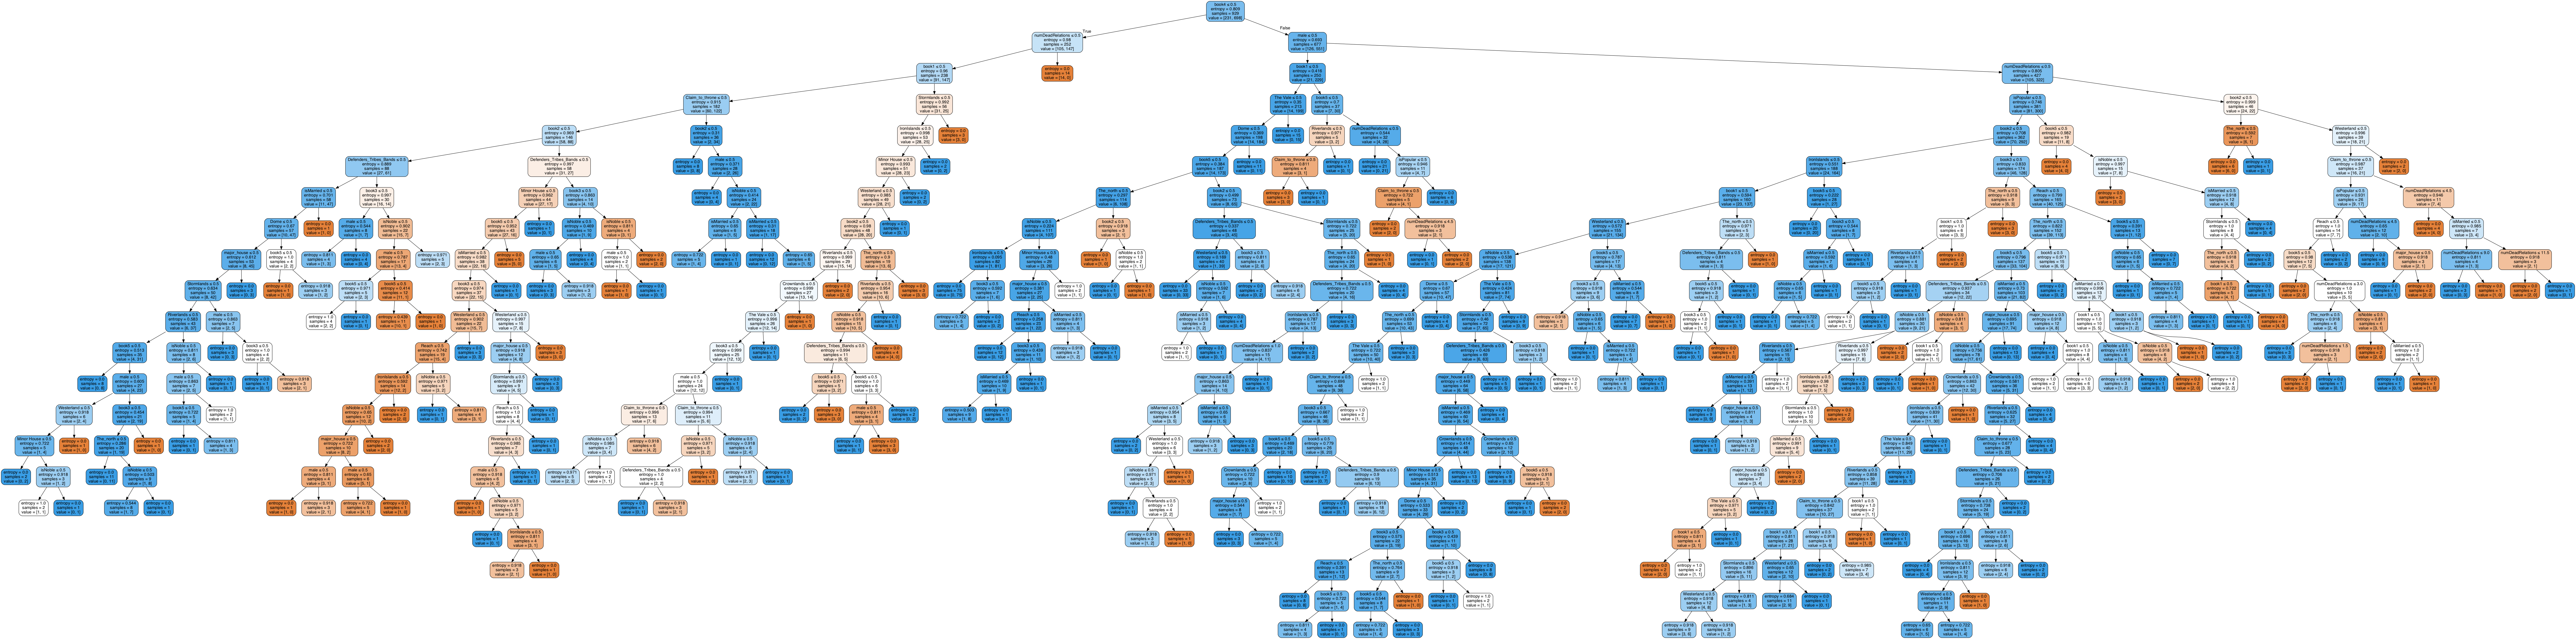

In [30]:
dot_data = StringIO()


export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names=feature_name)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Okay wow, that's a huge decision tree....how can we make this more efficient. Maybe lets see if we can increase accuracy, F-1, or both and make this a smaller tree. Let's try a Grid search

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    
    
}

In [32]:
gs_tree = GridSearchCV(clf, param_grid, cv = 3)
gs_tree.fit(X_train, y_train)
print('The best paramaters are ', gs_tree.best_params_)

The best paramaters are  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


Okay, now to tune our decision tree with these paramaters

In [33]:
clf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2)


In [34]:

clf2.fit(X_train,y_train) 
y_pred2 = clf2.predict(X_test)
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 25.7 µs


In [35]:
# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred2) * 100
print("Accuracy is :{0}".format(acc))



#Check F1 score for precision
f1score = f1_score(y_test, y_pred2) * 100

print('F1 score is :{0}'.format(f1score))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred2, rownames=['True'], colnames=['Predicted'], margins=True)



Accuracy is :80.7017543859649
F1 score is :89.20056100981768

Confusion Matrix
----------------


Predicted  0    1  All
True                  
0          4   76   80
1          1  318  319
All        5  394  399

In [36]:
accuracies.append(80.70)
f1s.append(89.20)

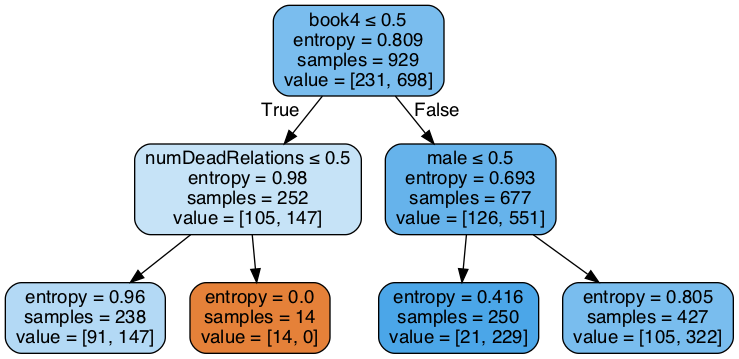

In [37]:
dot_data = StringIO()


export_graphviz(clf2, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names=feature_name)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Much nicer, but lets use an ensemble method so that we can test different types of trees to see how we're preforming. I'm thinking Random Forest.

In [38]:
#check if train test split is still fine
X_train.shape, X_test.shape, X.shape


((929, 23), (399, 23), (1328, 23))

In [39]:
forest = RandomForestClassifier(n_estimators=100)

In [40]:
#random forest

forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


In [41]:
#Check Accuracy
accuracy = accuracy_score(y_test, forest_pred) # accuracy

print('Accuracy score is :{0}'.format(accuracy))
#Check F1 score for precision
f1score = f1_score(y_test, forest_pred) * 100

print('F1 score is :{0}'.format(f1score))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, forest_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Accuracy score is :0.8070175438596491
F1 score is :88.13559322033899

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          36   44   80
1          33  286  319
All        69  330  399

In [42]:
accuracies.append(81.95)
f1s.append(89.09)

Okay so there's an improvement here. I'll run a grid search to see if I can improve on this model

In [43]:
gs_tree2 = GridSearchCV(forest, param_grid, cv = 3)
gs_tree2.fit(X_train, y_train)
print('The best paramaters are ', gs_tree2.best_params_)

The best paramaters are  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


Let's try with these paramaters

In [44]:
forest2 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=10)


In [45]:
forest2.fit(X_train, y_train)
forest_pred2 = forest2.predict(X_test)
%time

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 46 µs


In [46]:
#Check Accuracy
accuracy = accuracy_score(y_test, forest_pred2) # accuracy

print('Accuracy score is :{0}'.format(accuracy))
#Check F1 score for precision
f1score = f1_score(y_test, forest_pred2) * 100



print('F1 score is :{0}'.format(f1score))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, forest_pred2, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy score is :0.8320802005012531
F1 score is :89.894419306184

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          34   46   80
1          21  298  319
All        55  344  399

In [47]:
accuracies.append(84.71)
f1s.append(90.80)

Now....I have a BUNCH of features. I wonder if I can work with less features. Name of the game is efficiency. 

In [48]:
#function to plot features
def plot_feature_importances(model, data_train):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [49]:
#but also, let's see some numbers here
def feature_imp(model, x):
    return pd.Series(model.feature_importances_,index= X.columns).sort_values(ascending=False)


In [50]:
feature_imp(forest,X)

numDeadRelations          0.102496
book4                     0.096275
book5                     0.081002
book1                     0.072635
male                      0.072540
book3                     0.069173
isNoble                   0.067303
book2                     0.065837
isMarried                 0.056341
isPopular                 0.039170
Claim_to_throne           0.033968
The_north                 0.030974
Defenders_Tribes_Bands    0.030646
major_house               0.030018
Riverlands                0.027800
Westerland                0.023184
Stormlands                0.019205
IronIslands               0.018047
Reach                     0.017226
Crownlands                0.016662
Minor House               0.010461
Dorne                     0.009813
The Vale                  0.009222
dtype: float64

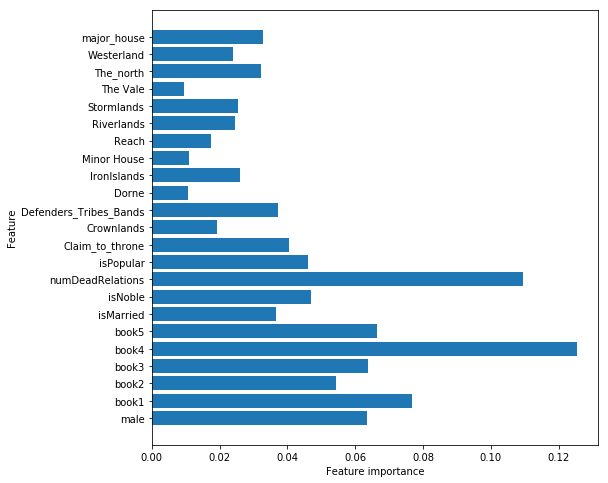

In [51]:
plot_feature_importances(forest2, X_train)

Great, I'm going to drop the bottom five and see if we can still obtain similar results as before without them

In [52]:
forest_bottom5 = ['Minor House','Reach','IronIslands','The Vale','Dorne']
newX = X.drop(forest_bottom5, axis = 1)
X_trainb5, X_testb5 , Y_trainb5, Y_testb5 = train_test_split(newX, y, test_size = 0.3, random_state = 100)


forestb5 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=2, min_samples_split=5)


In [53]:

forestb5.fit(X_trainb5,Y_trainb5)
forestb5pred = forestb5.predict(X_testb5)
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


In [54]:
#Accuracy
accuracy = accuracy_score(Y_testb5, forestb5pred)


#Check F1 score for precision
f1score = f1_score(Y_testb5, forestb5pred)


print('Accuracy score is :{0}'.format(accuracy))  
print('F1 score is :{0}'.format(f1score))
#Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(Y_testb5, forestb5pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy score is :0.8521303258145363
F1 score is :0.9107413010590016

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          39   41   80
1          18  301  319
All        57  342  399

In [55]:
accuracies.append(84.46)
f1s.append(90.69)

As expected that increased both of our metrics but the wall time is still the same. Let's see if we can bring down the time spent making this prediction by using the popular XGBoost model.

In [56]:
xclf = xgb.XGBClassifier()


In [57]:

xclf.fit(X_train, y_train)
xgb_preds = xclf.predict(X_test)
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


In [58]:


#Accuracy
accuracy = accuracy_score(y_test, xgb_preds)

#Check F1 score for precision
f1score = f1_score(y_test, xgb_preds)



print('Accuracy score is :{0}'.format(accuracy))
print('F1 score is :{0}'.format(f1score))
#Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, xgb_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy score is :0.8245614035087719
F1 score is :0.8952095808383234

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          30   50   80
1          20  299  319
All        50  349  399

In [59]:
accuracies.append(82.46)
f1s.append(89.52)

Huge change is time but a decrease in both our Accuracy and F-1 score. Let's see if fine tuning paramaters help

In [60]:

param_grid = {
    "learning_rate": [0.1, 0.001, 0.0001, .00001],
    'max_depth': [5, 10, 15],
    'min_child_weight': [10, 15],
    'subsample': [0.2, 0.5, 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [61]:
gs_tree3 = GridSearchCV(xclf, param_grid, cv = 3)
gs_tree3.fit(X_train, y_train)
print('The best paramaters are ', gs_tree3.best_params_)

The best paramaters are  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30, 'subsample': 0.7}


In [62]:
xclf2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=10, n_estimators=30, subsample = .7)

In [63]:

xclf2.fit(X_train, y_train)
xgb_preds2 = xclf2.predict(X_test)
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 33.9 µs


In [64]:


#Accuracy
accuracy = accuracy_score(y_test, xgb_preds2)

#Check F1 score for precision
f1score = f1_score(y_test, xgb_preds2)



print('Accuracy score is :{0}'.format(accuracy))
print('F1 score is :{0}'.format(f1score))
#Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, xgb_preds2, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy score is :0.8195488721804511
F1 score is :0.8938053097345133

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          24   56   80
1          16  303  319
All        40  359  399

In [65]:
accuracies.append(81.95)
f1s.append(89.38)

Let's see if we can drop some features.

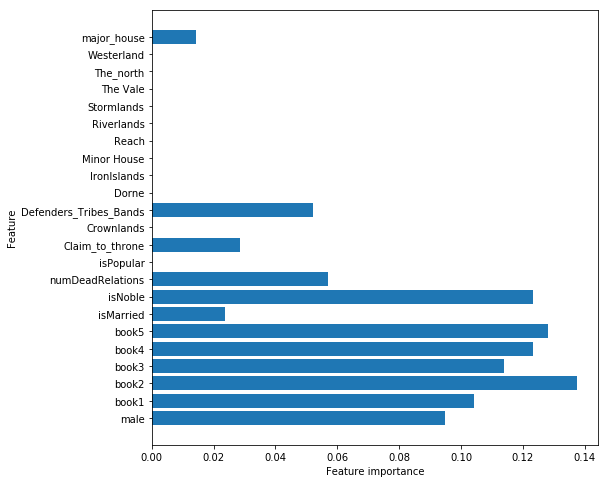

In [66]:
plot_feature_importances(xclf2, X_train)

In [67]:
feature_imp(xclf2,X)

book2                     0.137441
book5                     0.127962
book4                     0.123223
isNoble                   0.123223
book3                     0.113744
book1                     0.104265
male                      0.094787
numDeadRelations          0.056872
Defenders_Tribes_Bands    0.052133
Claim_to_throne           0.028436
isMarried                 0.023697
major_house               0.014218
Westerland                0.000000
isPopular                 0.000000
Dorne                     0.000000
IronIslands               0.000000
Minor House               0.000000
Reach                     0.000000
Riverlands                0.000000
Stormlands                0.000000
The Vale                  0.000000
The_north                 0.000000
Crownlands                0.000000
dtype: float32

Yah, let's drop all the features that have ZERO importance

In [68]:
x_bottom5 = ['Minor House','Reach','Westerland','The Vale','Crownlands' , 'Dorne', 'The_north', 'Stormlands', 'Riverlands', 'IronIslands', 'isPopular',]
xgbX = X.drop(x_bottom5, axis = 1)


In [69]:
X_trainxgb5, X_testxgb5 , Y_trainxgb5, Y_testxgb5 = train_test_split(xgbX, y, test_size = 0.3, random_state = 100)

xgb5 = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=10, n_estimators=30, subsample = .7)

In [70]:

xgb5.fit(X_trainxgb5,Y_trainxgb5)
xgb5_preds = xgb5.predict(X_testxgb5)
%time

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 14.1 µs


In [71]:
#Accuracy
accuracy = accuracy_score(y_test, xgb5_preds)

#Check F1 score for precision
f1score = f1_score(y_test, xgb5_preds)



print('Accuracy score is :{0}'.format(accuracy))
print('F1 score is :{0}'.format(f1score))
#Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(Y_testxgb5, xgb5_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy score is :0.8095238095238095
F1 score is :0.8858858858858859

Confusion Matrix
----------------


Predicted   0    1  All
True                   
0          28   52   80
1          24  295  319
All        52  347  399

In [72]:
accuracies.append(80.95)
f1s.append(88.59)

In [73]:
len(accuracies)

8

In [74]:
len(f1s)

8

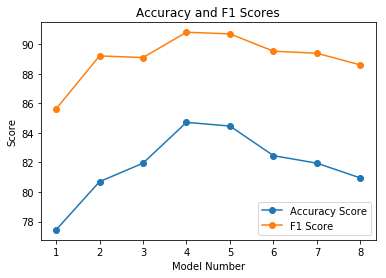

Text(0.5, 1.0, 'Model Performance Time in Seconds')

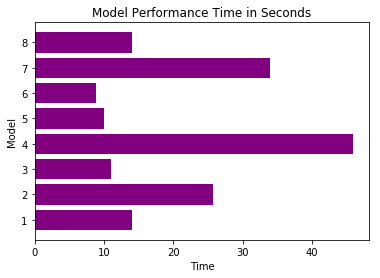

In [101]:
x = [1,2,3,4,5,6,7,8]
times = [14.1, 25.7, 11, 46, 10, 8.82, 33.9, 14.1]
plt.plot(x, accuracies, '-o', label = 'Accuracy Score')
plt.plot(x,f1s , '-o',  label = 'F1 Score')
plt.ylabel('Score')
plt.xlabel('Model Number')
plt.title('Accuracy and F1 Scores')
plt.legend()
plt.show()
plt.barh(x, times, color = 'purple')
plt.ylabel('Model')
plt.xlabel('Time')
plt.title('Model Performance Time in Seconds')


In [110]:
print('Accuracy for Model 5:', accuracies[4], ', Time for Model 5:', times[4], ', F1 Score Model 5:', f1s[4])
print('Accuracy for Model 6:', accuracies[5], ', Time for Model 5:', times[5], ', F1 Score Model 5:', f1s[5])

Accuracy for Model 5: 84.46 , Time for Model 5: 10 , F1 Score Model 5: 90.69
Accuracy for Model 6: 82.46 , Time for Model 5: 8.82 , F1 Score Model 5: 89.52


Based on our graphs of Time spent running a model, accuracies, and F1scores the two models that are neck and neck are model 5 and 6. The variation in result are miniscule so it's hard to determine which model to choose based on these numbers alone. However, Model 5 uses five fewer features than Model 6 and exceeds Model 6 in both accuracy and F1 scores while perfoming only 1.8 seconds slower than Model 6. It's safe to say that Model Five is the most efficient model. 

Now for the fun part. Let's test the models.

In [112]:
df = pd.read_csv('character-predictions.csv')

# First up, fan favorite ARYA STARK 



<img src='Arya-Stark-game-of-thrones-38983548-540-275.gif'>

In [130]:
arya = df.loc[df['name'] == 'Arya Stark']

In [131]:
arya

S.No  actual  pred  alive   plod        name     title  male   culture  \
1466  1467       1     0  0.315  0.685  Arya Stark  Princess     0  Northmen   

      dateOfBirth  ...  isAliveHeir isAliveSpouse isMarried isNoble   age  \
1466        289.0  ...          NaN           NaN         0       1  16.0   

     numDeadRelations  boolDeadRelations  isPopular  popularity  isAlive  
1466                8                  1          1         1.0        1  

[1 rows x 33 columns]

In [132]:
arya.house

1466    House Stark
Name: house, dtype: object

In [133]:
arya.columns

Index(['S.No', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'male',
       'culture', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir',
       'house', 'spouse', 'book1', 'book2', 'book3', 'book4', 'book5',
       'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse',
       'isMarried', 'isNoble', 'age', 'numDeadRelations', 'boolDeadRelations',
       'isPopular', 'popularity', 'isAlive'],
      dtype='object')

In [134]:
arya.drop(['S.No', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'isAlive', 
       'culture', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir',
       'house', 'spouse','isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse','age',  'boolDeadRelations',
        'popularity'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [135]:
arya['Claim_to_throne'] = 1
arya['Defenders_Tribes_Bands'] = 0
arya['major_house'] = 0
arya['The_north'] = 0
arya['Westerland'] = 0
arya['Stormland'] = 0
arya['Riverlands'] = 0
arya['Crownlands'] = 0 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [136]:
arya.columns

Index(['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried',
       'isNoble', 'numDeadRelations', 'isPopular', 'Claim_to_throne',
       'Defenders_Tribes_Bands', 'major_house', 'The_north', 'Westerland',
       'Stormland', 'Riverlands', 'Crownlands'],
      dtype='object')

In [137]:

forestb5.predict(arya)


array([1])

YAY, it's correct. However, knowing that Arya is going to survive isn't a huge feat. Also, Let's try for a random character and someone we know is definitely dead

In [138]:

addison = df.loc[df['name'] == 'Addison Hill']

In [139]:
robb = df.loc[df['name'] == 'Robb Stark']

In [140]:
addison

S.No  actual  pred  alive   plod          name title  male culture  \
2     3       1     0  0.493  0.507  Addison Hill   Ser     1     NaN   

   dateOfBirth  ...  isAliveHeir isAliveSpouse isMarried isNoble age  \
2          NaN  ...          NaN           NaN         0       1 NaN   

  numDeadRelations  boolDeadRelations  isPopular  popularity  isAlive  
2                0                  0          0    0.267559        1  

[1 rows x 33 columns]

In [141]:
addison.house



2    House Swyft
Name: house, dtype: object

In [142]:
addison.isAlive

2    1
Name: isAlive, dtype: int64

In [143]:
robb.house # yah but we know it's Stark

101    NaN
Name: house, dtype: object

In [144]:
robb.isAlive

101    0
Name: isAlive, dtype: int64

In [145]:
robb.drop(['S.No', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'isAlive', 
       'culture', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir',
       'house', 'spouse','isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse','age',  'boolDeadRelations',
        'popularity'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [146]:
addison.drop(['S.No', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'isAlive', 
       'culture', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir',
       'house', 'spouse','isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse','age',  'boolDeadRelations',
        'popularity'], axis = 1, inplace = True)

In [147]:
addison['Claim_to_throne'] = 0
addison['Defenders_Tribes_Bands'] = 0
addison['major_house'] = 0
addison['The_north'] = 0
addison['Westerland'] = 1
addison['Stormland'] = 0
addison['Riverlands'] = 0
addison['Crownlands'] = 0 

robb['Claim_to_throne'] = 1
robb['Defenders_Tribes_Bands'] = 0
robb['major_house'] = 0
robb['The_north'] = 0
robb['Westerland'] = 0
robb['Stormland'] = 0
robb['Riverlands'] = 0
robb['Crownlands'] = 0 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

First, Addison. She's not popular enough to have an actor playing here so here's a dragon

<img src='dragon.webp'>

In [148]:
 
forestb5.predict(addison)

array([1])

YAY it's correct! Now let's try Rob.

<img src='robb.gif'>

In [149]:
forestb5.predict(robb)

array([0])

So, obviously not a perfect model but three correct prdictions in a row aren't bad odds. I'll take it!


<img src='boom.gif'>